<a href="https://colab.research.google.com/github/dcolinmorgan/grph/blob/main/single_cell_after_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial: Quick single-cell transcriptomics using GPU UMAP analysis & visualization

Using GPU-accelerated UMAP analysis & visualization, single cell data can be analyzed faster and much more easily explored.

* Task: Analyze single cell's gene expression for clustering
* Data: 5 independent datasets of roughly 30K rows of 200 columns of single cell 
* [data](https://cytotrace.stanford.edu/#shiny-tab-dataset_download) 
* [paper](https://arxiv.org/pdf/2208.05229.pdf)

**Insight/ Result:**

1.   over 5x faster for entire ~10000 cell samples (102s vs 18s)
3.   Offers more insight when static plot would otherwise fail


(See also: [CPU baseline](https://github.com/dcolinmorgan/grph/blob/main/standard_single_cell_umap_demo.ipynb))

## Setup

(install cuda packages first)

### install

In [ ]:
# !pip install --extra-index-url=https://pypi.nvidia.com cuml-cu11==22.10.0 cudf-cu11==22.10.0 cugraph-cu11==22.10.0 pylibraft_cu11==22.10.0 raft_dask_cu11==22.10.0 dask_cudf_cu11==22.10.0 pylibcugraph_cu11==22.10.0 pylibraft_cu11==22.10.0
# !pip install graphistry
# !pip install scanpy

### import / configure

#### get a free api-key at https://www.graphistry.com/

In [10]:
import scanpy as sc
import anndata

import graphistry

# graphistry.register(api=3,protocol="https", server="hub.graphistry.com", username='dcolinmorgan', password='***') ## key id, secret key
graphistry.__version__


'0.28.7'

In [2]:
!nvidia-smi

Thu Mar  2 07:24:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    23W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !git clone https://github.com/dcolinmorgan/rapidsai-csp-utils/tree/patch-1 
# !python rapidsai-csp-utils/colab/pip-install.py

import cuml
cuml.__version__

# import cupy
# cudf.__version__

'22.10.00a+119.gb30ef85c1'

In [4]:
import os, time
from collections import Counter
import cProfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pstats import Stats
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 200)

## Data Download & Description

In [ ]:
#download 6 single cell datasets
%%bash
wget -nc -q https://www.dropbox.com/s/h1k7jy0kad6fguu/GSE107910_40.h5ad.zip
wget -nc -q https://www.dropbox.com/s/xza477kxj7vgdlr/GSE67123_6.h5ad.zip

unzip -o GSE107910_40.h5ad.zip
unzip -o GSE67123_6.h5ad.zip

mkdir -p single_cell
mv *.h5ad single_cell

In [5]:

list_files = []
for dirname, _, filenames in os.walk('single_cell'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        list_files.append(os.path.join(dirname, filename))

for fn in list_files:
    adata = sc.read(fn) # sc.read_h5ad
    print( adata.uns['info'] )
    print()

['Thymus (Drop-seq)' 'Validation' '15429' '9307.0' 'nan' '9307' '19530'
 '8' '8' 'UMI' 'Mouse' '1' 'Thymus' 'Drop-seq' 'Timepoints' 'in vivo'
 '29884461' '20180619' 'GSE107910' 'Immunity'
 'Only hematopoietic cells, selected based on detectable Ptprc expression, were considered in this dataset. ']

['Embryonic HSCs (Tang et al.)' 'Validation' '143' 'nan' 'nan' '143'
 '24028' '5' '5' 'TPM/FPKM' 'Mouse' '1' 'Embryo' 'Tang et al.'
 'Timepoints' 'in vivo' '27225119' '20160526' 'GSE67123' 'Nature' 'nan']



# scanpy read and compute UMAP for GSE107910_40 Murine Thymus cells




In [39]:
fn='single_cell/GSE107910_40.h5ad'
adata = sc.read(fn) # sc.read_h5ad
str_data_inf = fn.split('/')[1].split('.')[0] + ' ' + str(adata.X.shape)+'\n' + adata.uns['info'][0]

EE=pd.DataFrame(adata.X,columns=adata.uns['gcsGenesNames'],index=adata.uns['allcellnames'])
g1=graphistry.nodes(EE.reset_index(),"index") #,columns=adata1.uns['gcsGenesNames']))

t0 = time.time()

g11 = g1.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

print('Total ', np.round(time.time() - t0,1), 'seconds passed')


Total  18.7 seconds passed


In [38]:
EE.head()
print(EE.shape)

(9307, 18335)


In [11]:
emb1=g11._node_embedding
g111=graphistry.nodes(emb1.reset_index(),'index').edges(g11._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g111.plot()

## this paper was specifically interested in peak mitosis genes, ie ["Tirosh" genes](https://genome.cshlp.org/content/25/12/1860.short), so lets zoom in on those

In [40]:
S_phase_genes_Tirosh = ['MCM5', 'PCNA', 'TYMS', 'FEN1', 'MCM2', 'MCM4', 'RRM1', 'UNG', 'GINS2', 'MCM6', 'CDCA7', 'DTL', 'PRIM1', 'UHRF1', 'MLF1IP', 'HELLS', 'RFC2', 'RPA2', 'NASP', 'RAD51AP1', 'GMNN', 'WDR76', 'SLBP', 'CCNE2', 'UBR7', 'POLD3', 'MSH2', 'ATAD2', 'RAD51', 'RRM2', 'CDC45', 'CDC6', 'EXO1', 'TIPIN', 'DSCC1', 'BLM', 'CASP8AP2', 'USP1', 'CLSPN', 'POLA1', 'CHAF1B', 'BRIP1', 'E2F8']
G2_M_genes_Tirosh = ['HMGB2', 'CDK1', 'NUSAP1', 'UBE2C', 'BIRC5', 'TPX2', 'TOP2A', 'NDC80', 'CKS2', 'NUF2', 'CKS1B', 'MKI67', 'TMPO', 'CENPF', 'TACC3', 'FAM64A', 'SMC4', 'CCNB2', 'CKAP2L', 'CKAP2', 'AURKB', 'BUB1', 'KIF11', 'ANP32E', 'TUBB4B', 'GTSE1', 'KIF20B', 'HJURP', 'CDCA3', 'HN1', 'CDC20', 'TTK', 'CDC25C', 'KIF2C', 'RANGAP1', 'NCAPD2', 'DLGAP5', 'CDCA2', 'CDCA8', 'ECT2', 'KIF23', 'HMMR', 'AURKA', 'PSRC1', 'ANLN', 'LBR', 'CKAP5', 'CENPE', 'CTCF', 'NEK2', 'G2E3', 'GAS2L3', 'CBX5', 'CENPA']
u = 'allgenenames'
list_genes_upper = [t.upper() for t in adata.uns[u] ]
I = np.where( pd.Series(list_genes_upper).isin( S_phase_genes_Tirosh + G2_M_genes_Tirosh ) )[0]


In [42]:
EE=pd.DataFrame(adata.X[:,I],columns=adata.uns['gcsGenesNames'][I],index=adata.uns['allcellnames'])
g1=graphistry.nodes(EE.reset_index(),"index") #,columns=adata1.uns['gcsGenesNames']))

t0 = time.time()

g11 = g1.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )


print('Total ', np.round(time.time() - t0,1), 'seconds passed')


Total  9.6 seconds passed


In [45]:
print(EE.shape)

(9307, 96)


In [33]:
emb1=g11._node_embedding
g111=graphistry.nodes(emb1.reset_index(),'index').edges(g11._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g111.plot()

# GSE67123_6 Embryonic HSCs



*   static t-SNE and UMAP are not so telling...
*   interactive plot allows more thorough investigations



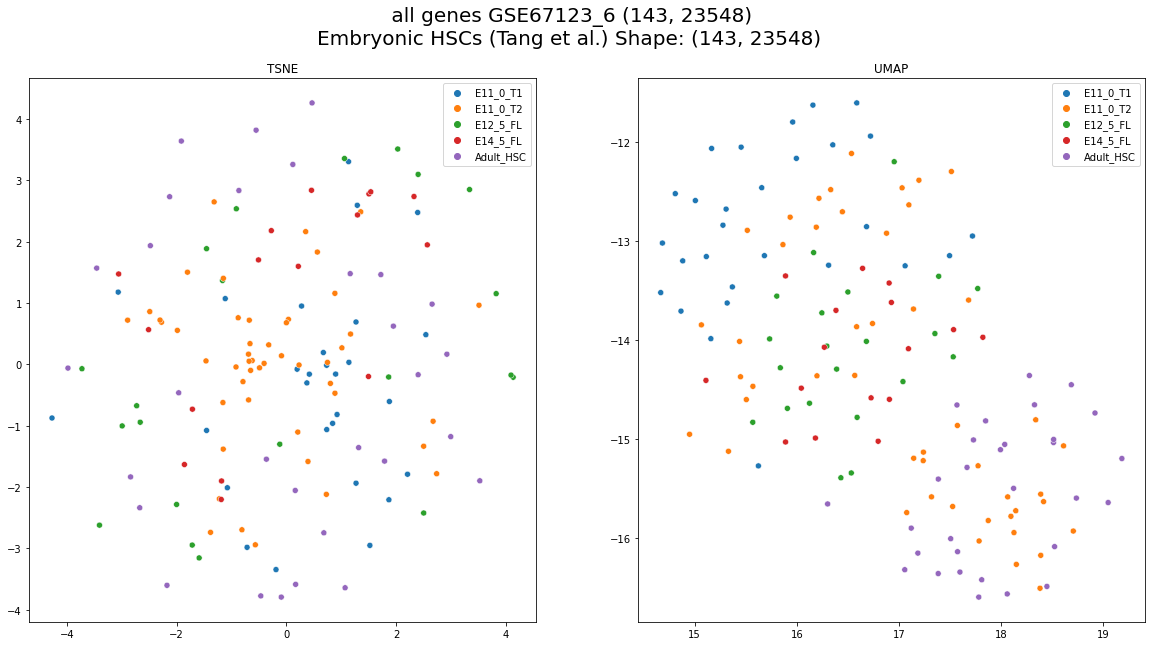

In [19]:
fig,ax = plt.subplots(1,2, figsize = (20,10)); c = 0
ax[0].set_title('TSNE')
ax[1].set_title('UMAP')
plt.suptitle(' all genes ' +str_data_inf_2 + ' Shape: ' + str(adata2.X.shape) , fontsize = 20  )

sns.scatterplot(x = adata2.uns['X_tsne'][:,0], y = adata2.uns['X_tsne'][:,1]  , hue = adata2.uns['Phenotype'],ax=ax[0])

sns.scatterplot(x = adata2.uns['X_umap'][:,0], y = adata2.uns['X_umap'][:,1]  , hue = adata2.uns['Phenotype'],ax=ax[1])

plt.show()

In [17]:
t0 = time.time()

fn='single_cell/GSE67123_6.h5ad'
adata2 = sc.read(fn) # sc.read_h5ad
str_data_inf_2 = fn.split('/')[1].split('.')[0] + ' ' + str(adata2.X.shape)+'\n' + adata2.uns['info'][0]

EE=pd.DataFrame(adata2.X,columns=adata2.uns['gcsGenesNames'],index=adata2.uns['allcellnames'])
g2=graphistry.nodes(EE.reset_index(),"index")#,columns=adata1.uns['gcsGenesNames']))

g22 = g2.umap(
            use_scaler='robust', ## zscale, minmax, standard, normal,
            n_components=2,
            n_neighbors=12,
            engine='cuml'
    )

print('Total ', np.round(time.time() - t0,1), 'seconds passed')


Total  6.8 seconds passed


In [18]:
emb2=g22._node_embedding
g222=graphistry.nodes(emb2.reset_index(),'index').edges(g22._edges,'_src_implicit','_dst_implicit').bind(point_x="x",point_y="y").settings(url_params={"play":0})
g222.plot()